<p style="font-size:30px; text-align:center; line-height:120%">
    <br> 
        <b>
        COMS 4761 Computational Genomics 
        <br></br>
            Protein Structure Prediction
        <br></br>
        </b> 
    <br> 
</p>
<p style="font-size:18px; text-align:left; line-height:120%">
    <br> 
        <b>
        Name: Anushri Arora, Kirit Dhillon
        </b>
    <br> 
</p>

In [34]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from networkx.algorithms.components.connected import connected_components
import warnings
import networkx
import numpy as np
import json
import nltk
from nltk.corpus import stopwords
import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt

In [64]:
#df = pd.read_csv('/content/drive/My Drive/small_kaggle_clean.csv')
df = pd.read_csv('small_kaggle_clean.csv')
print(df.shape)

(206, 7)


### Preprocessing

In [65]:
def preprocess(df):
    print("Shape before preprocessing: ",df.shape)
    df = df.drop_duplicates(subset='seq', keep="first")
    for index, row in df.iterrows():
        if len(row['seq']) % 3 != 0 or '*' in row['seq']:
            df.drop(index, inplace=True)
    print("Shape after preprocessing: " ,df.shape)
    return df

In [66]:
df = preprocess(df)
df = df.reset_index(drop=True)

Shape before preprocessing:  (206, 7)
Shape after preprocessing:  (49, 7)


In [67]:
print(df.head(10))

  pdb_id chain_code              seq             sst8             sst3  len  \
0   3N9L          B  ARTKQTARKSTGGKA  CCEEECCCCCCCCCC  CCEEECCCCCCCCCC   15   
1   3O6L          C  EPVDPKLEPWKHPGS  CCSSCCCCTTCCCCC  CCCCCCCCCCCCCCC   15   
2   3O7L          I  VQYLTRSAIRRASTI  CCCCSTTTSCCCCCC  CCCCCCCCCCCCCCC   15   
3   3OQY          a  KETAAAKFERQHMDS  CCCHHHHHHHHHBCC  CCCHHHHHHHHHECC   15   
4   3PGC          C  KMRMATPLLMQALPM  CCCCCCCCCCEECCC  CCCCCCCCCCEECCC   15   
5   3PTH          B  ELNPNAEVWGAPVLH  CCCTTCCCTTCCCCC  CCCCCCCCCCCCCCC   15   
6   3QXA          C  PVSKMRMATPLLMQA  CCCBCCCCCCCCCCC  CCCECCCCCCCCCCC   15   
7   3RC0          P  RKRTYETFKSIMKKS  CCCCCCCSBCCCCCC  CCCCCCCCECCCCCC   15   
8   3SVM          P  YEPSTTARKVGRPGR  CCCCCEECCSCCCCC  CCCCCEECCCCCCCC   15   
9   3U86          B  SPGRLFPGAPPTAKK  CCCCCSTTCCCCSCC  CCCCCCCCCCCCCCC   15   

   has_nonstd_aa  
0          False  
1          False  
2          False  
3          False  
4          False  
5          False

In [68]:
def process_n_dump_to_csv(data):
    df = preprocess(data)
    print("Size of dataframe: ", len(df))
    df.to_csv("sentences.csv")
    return df

In [69]:
wordmodelfile ='protVec_clean.txt'
wordmodel = KeyedVectors.load_word2vec_format(wordmodelfile, binary = False, limit=200000)

In [70]:
def seq_grams(s1):
    '''
    i/p:  protein sequence
    o/p:  list where each element has 3 chars 
    '''
    s1_words=[]
    for count in range(0,len(s1)-2):
        s1_words.append(s1[count:count+3])
        count+=3
    return s1_words

def similarityIndex(s1, s2, wordmodel):
    '''
    To compare two protein sequences and return their similarity score based on the gensim model
    '''
    if s1 == s2:
        return 1.0
    
    s1words = seq_grams(s1)
    s2words = seq_grams(s2)

    s1words = list(s1words)
    s2words = list(s2words)    

    s1set = set(s1words)
    s2set = set(s2words)

    vocab = wordmodel.vocab
    
    if len(s1set & s2set) == 0:
        return 0.0
    for word in s1set.copy():
        if (word not in vocab):
            s1words.remove(word)
    for word in s2set.copy():
        if (word not in vocab):
            s2words.remove(word)
    try:
        s = wordmodel.n_similarity(s1words, s2words)
    except:
        s = 0
    return s


In [71]:
n = df.shape[0]
similarity_matrix = [[-1 for c in range(n)] for r in range(n)]
row = 0
for seq_1 in df['seq']:
    column = 0
    for seq_2 in df['seq']:
        if seq_1 == seq_2:
            column += 1
            continue
        similarity_matrix[row][column] = similarityIndex(seq_1, seq_2, wordmodel)
        column += 1
    row += 1

In [72]:
setlist = []
index = 0
for score_row, response in zip(similarity_matrix, df['seq']):
    max_sim_index = index
    if np.array(score_row).sum() > 0:
        max_sim_index = np.array(score_row).argmax()
    if set([response, df['seq'][max_sim_index]]) not in setlist:
        setlist.append([response, df['seq'][max_sim_index]])
    index += 1

In [73]:
def toGraph(l):
    '''
    It takes in a list of lists and returns a graph object, 
    assigning nodes and edges from each sub-list object
    '''
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(toEdges(part))
    return G

def toEdges(l):
    '''
    It treats args(1) 'l' as a graph and returns (implicitly) it's edges 
    '''
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current 

In [74]:
G = toGraph(setlist)
setlist = list(connected_components(G))

In [75]:
novel_sub_categories = {}
index = 0
for category in setlist:
    novel_sub_categories[index] = list(category)
    index += 1

result = novel_sub_categories
pprint.pprint(result)

{0: ['SPGRLFPGAPPTAKK',
     'PVLFPGQPFGQPPLG',
     'ARTKQTARKSTGGKA',
     'YEPSTTARKVGRPGR'],
 1: ['EPVDPKLEPWKHPGS'],
 2: ['VQYLTRSAIRRASTI'],
 3: ['KETAAAKFERQHMDS', 'KETAAACFERCHMDS'],
 4: ['KMRMATPLLMQALPM', 'PVSKMRMATPLLMQA'],
 5: ['HENIDWGEPKDKEVW', 'ELNPNAEVWGAPVLH'],
 6: ['RKRTYETFKSIMKKS', 'LSRVKSLKKSLRQSF'],
 7: ['AVPIAQKSEPHSLSS', 'PQAQQKSLLQQLLTE'],
 8: ['RTFRQVQSSISDFYD'],
 9: ['RHKILHRLLQEGSPS', 'LTERHKILHRLLQEG'],
 10: ['LPQDRGFLVVQGDPR'],
 11: ['APRRLPIFNRISVSE', 'KKESRVVVWRLPPLH'],
 12: ['ASEDELVAEFLQDQN'],
 13: ['DGTCVAARTRPVLSY', 'SPQGGGPWDSVARVL', 'NTGRTEAWKVLSPQG'],
 14: ['STASTVEYSTVVHSG', 'KSAVTTVVNPKYEGK'],
 15: ['GELIGILNAAKVPAD'],
 16: ['RRRPRPPYLPRPRPP', 'GGRRRRRTWYFGGGK', 'DLSPRPSPNPHPVSQ'],
 17: ['SLMRVQAHIRKRMVA', 'GSLLRVQAHIRKKMV'],
 18: ['SQETFSDLWKLLPEN'],
 19: ['QKVTFPKMKIPKFTF'],
 20: ['TTGEIIGDIRQAHCN'],
 21: ['ATEYRVRVNSAYQDK'],
 22: ['NLGLEDIIRKALMGS'],
 23: ['DFSIVGSLPRDFELS'],
 24: ['APATGGVKKPHRYRP', 'SAPATGGVKKPHRYR'],
 25: ['KMLEGQNAHFRYKNR

In [76]:
with open('clusters.json', 'w') as temp:
    json.dump(result, temp)

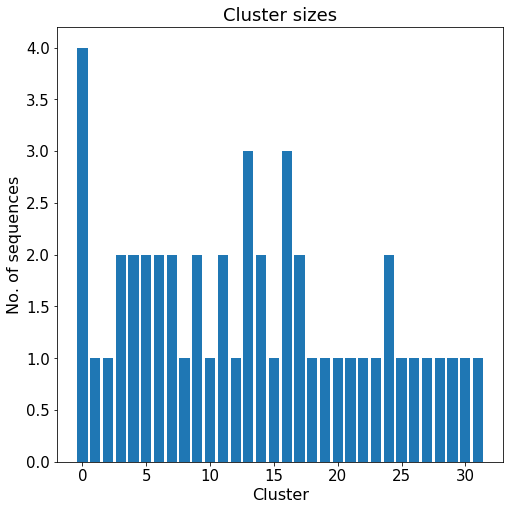

In [77]:
fig = plt.figure(figsize=(8, 8))
x = result.keys()
y = [len(value) for value in result.values()]
plt.bar(x, y)
plt.title("Cluster sizes", size=18)
plt.xlabel("Cluster", size = 16)
plt.ylabel("No. of sequences", size = 16)
plt.tick_params(labelsize=15);

In [85]:
# Get clusters with more than one sequence
def get_multiple_seq_clusters(result):
    clusters = {}
    count = 0
    for k, v in result.items():
        if len(v) > 1:
            clusters[count] = v
            count+=1
    return clusters

In [86]:
clusters = get_multiple_seq_clusters(result)
pprint.pprint(clusters)

{0: ['SPGRLFPGAPPTAKK',
     'PVLFPGQPFGQPPLG',
     'ARTKQTARKSTGGKA',
     'YEPSTTARKVGRPGR'],
 1: ['KETAAAKFERQHMDS', 'KETAAACFERCHMDS'],
 2: ['KMRMATPLLMQALPM', 'PVSKMRMATPLLMQA'],
 3: ['HENIDWGEPKDKEVW', 'ELNPNAEVWGAPVLH'],
 4: ['RKRTYETFKSIMKKS', 'LSRVKSLKKSLRQSF'],
 5: ['AVPIAQKSEPHSLSS', 'PQAQQKSLLQQLLTE'],
 6: ['RHKILHRLLQEGSPS', 'LTERHKILHRLLQEG'],
 7: ['APRRLPIFNRISVSE', 'KKESRVVVWRLPPLH'],
 8: ['DGTCVAARTRPVLSY', 'SPQGGGPWDSVARVL', 'NTGRTEAWKVLSPQG'],
 9: ['STASTVEYSTVVHSG', 'KSAVTTVVNPKYEGK'],
 10: ['RRRPRPPYLPRPRPP', 'GGRRRRRTWYFGGGK', 'DLSPRPSPNPHPVSQ'],
 11: ['SLMRVQAHIRKRMVA', 'GSLLRVQAHIRKKMV'],
 12: ['APATGGVKKPHRYRP', 'SAPATGGVKKPHRYR']}


In [133]:
def compute_sst3_similarity(clusters):
    sst3_similarities = {}
    for key, cluster in clusters.items():
        temp_sst3 = []
        for seq in cluster:
            hit = df.loc[df['seq'] == seq]
            sst3 = np.array(hit['sst3'])[0]
            if sst3 not in temp_sst3:
                temp_sst3.append(sst3)
        sst3_similarities[key] = 1 - len(temp_sst3)/len(cluster)
    return sst3_similarities

In [134]:
pprint.pprint(compute_sst3_similarity(clusters))

{0: 0.25,
 1: 0.5,
 2: 0.0,
 3: 0.5,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0}


In [145]:
def assign_color_to_ratio(ratios):
    colors = []
    for ratio in ratios:
        if ratio < 0.25:
            colors.append('red')
        elif ratio < 0.5:
            colors.append('orange')
        else:
            colors.append('green')
    return colors

Text(0,0.5,'Similarity Ratio')

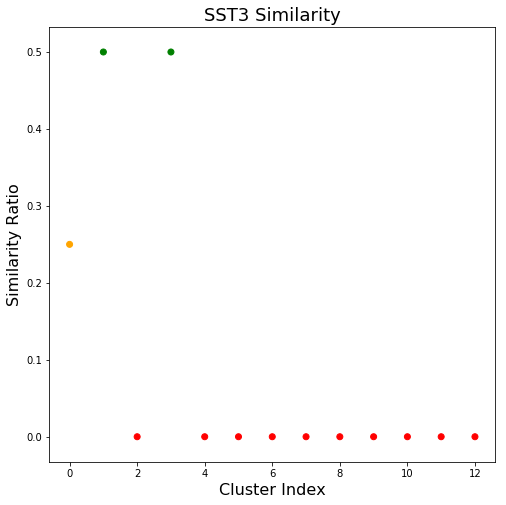

In [148]:
fig = plt.figure(figsize=(8,8))
sst3_similarities = compute_sst3_similarity(clusters)
x = sst3_similarities.keys()
y = sst3_similarities.values()
color_vals = assign_color_to_ratio(y)
plt.scatter(x, y, c=color_vals)
plt.title("SST3 Similarity", size=18)
plt.xlabel("Cluster Index", size=16)
plt.ylabel("Similarity Ratio", size=16)

### Results
The above plot shows the degree of similarity of secondary structures between sequences within each cluster. 
- Red = uncorrelated SST3
- Green = correlated SST3